<a href="https://colab.research.google.com/github/BehnamLatifi/Sample-Project/blob/main/Build_a_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Generative Adversarial Network

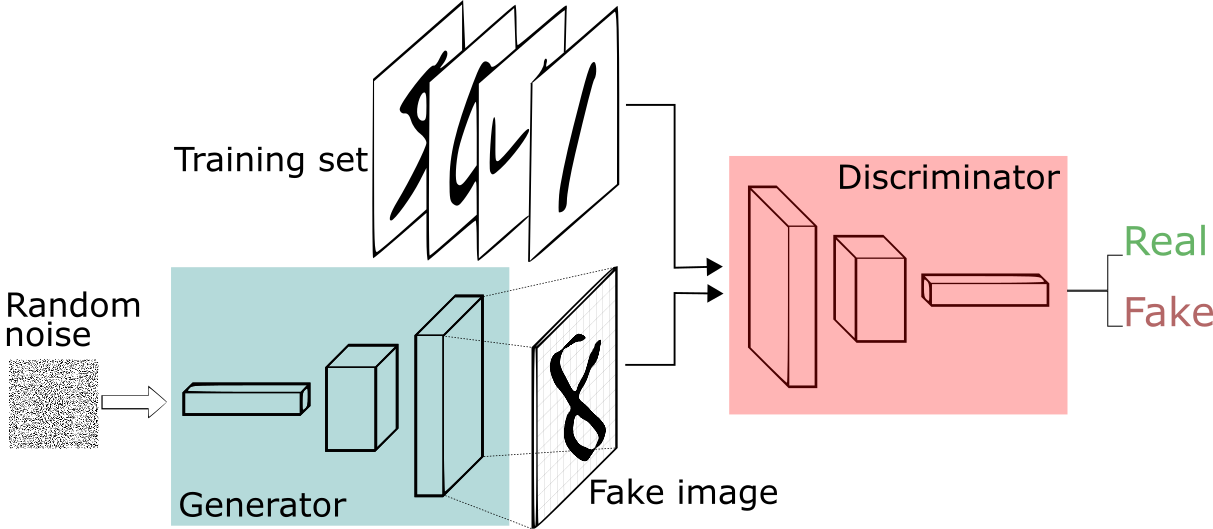

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from torchvision import datasets, transforms as T

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from torch import nn
from torch.nn import Sequential, Conv2d, ConvTranspose2d, BatchNorm2d, Linear, ReLU, Tanh, LeakyReLU, Flatten
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

try:
  from torchsummary import summary
except:
  #In case if torch summary is not installed
  !pip install torchsummary
  from torchsummary import summary

# Configurations

In [ ]:
device = 'cuda'
batch_size = 128
noise_dim = 64

# optimizers parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# training variables
epochs = 100

# Load MNIST Dataset

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)
])

In [ ]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

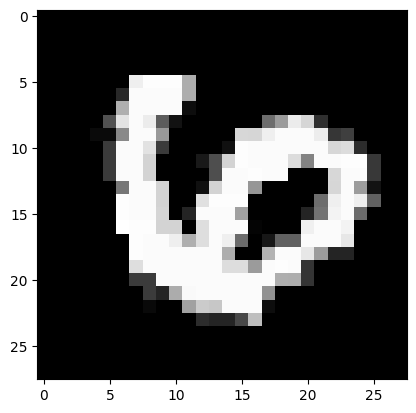

In [ ]:
image, label = trainset[9000]
plt.imshow(image.squeeze(), cmap = 'gray')
plt.show();

In [ ]:
print("total images present in trainset are :", len(trainset))

total images present in trainset are : 60000


# Load Dataset Into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print("total number of batches in trainloader :", len(trainloader))

total number of batches in trainloader : 469


In [ ]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

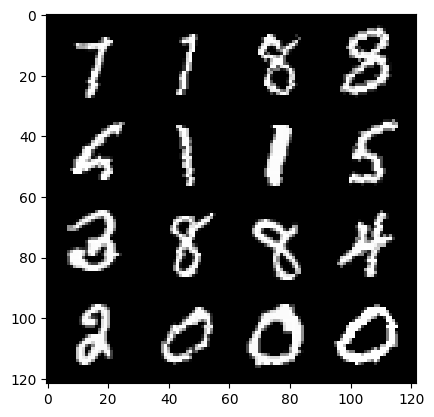

In [ ]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return Sequential(
      Conv2d(in_channels, out_channels, kernel_size, stride),
      BatchNorm2d(out_channels),
      LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.block_1 = get_disc_block(1, 16, (3, 3), 2)
    self.block_2 = get_disc_block(16, 32, (5, 5), 2)
    self.block_3 = get_disc_block(32, 64, (5, 5), 2)
    self.flatten = Flatten()
    self.linear = Linear(in_features = 64, out_features = 1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)
    return x5

In [ ]:
D = Discriminator()
D.to(device)
summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return Sequential(
        ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        Tanh()
    )
  return Sequential(
      ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      BatchNorm2d(out_channels),
      ReLU()
  )

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3, 3), 2)
    self.block_2 = get_gen_block(256, 128, (4, 4), 1)
    self.block_3 = get_gen_block(128, 64, (3, 3), 2)
    self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block = True)

  def forward(self, r_noise_vec):
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1) # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)
    return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, Conv2d) or isinstance(m, ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = Adam(D.parameters(), lr = lr, betas = [beta_1, beta_2])
G_opt = Adam(G.parameters(), lr = lr, betas = [beta_1, beta_2])

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6856496768719607 | G_loss : 0.6896353222922221


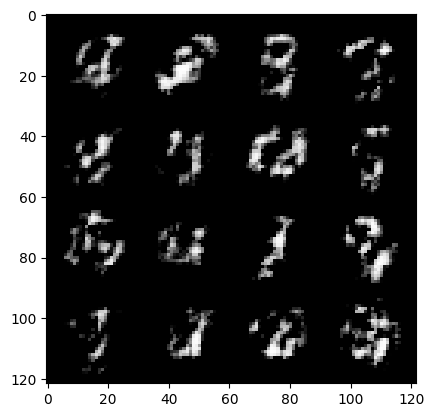

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6784271272514929 | G_loss : 0.71169141004843


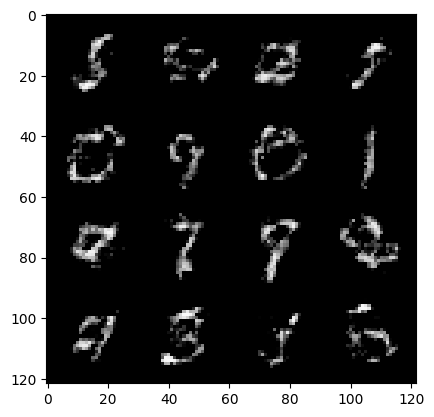

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6399308430360579 | G_loss : 0.7571077330280215


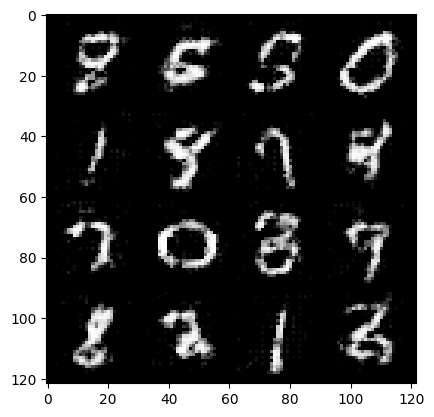

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6175963060179753 | G_loss : 0.7886256486622255


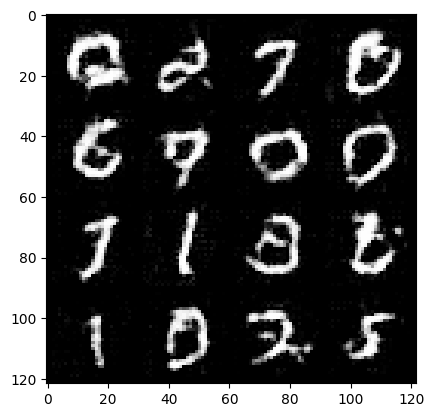

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.6148444917410422 | G_loss : 0.8015297516576771


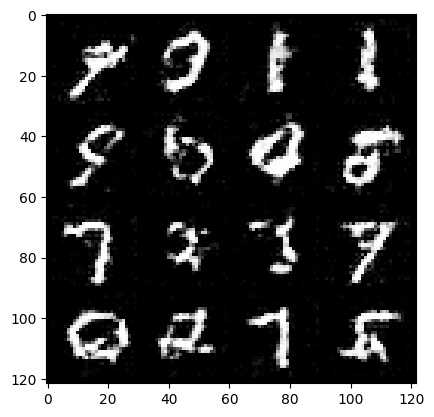

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.6143616556104566 | G_loss : 0.8138571723437766


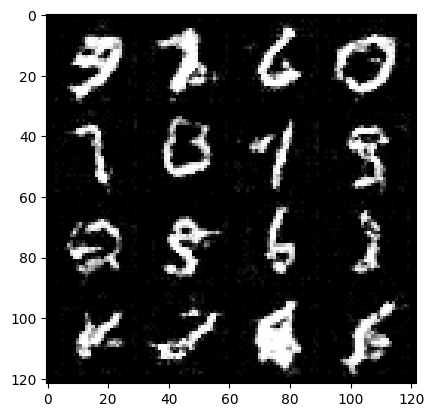

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6192626477812907 | G_loss : 0.8152390502409131


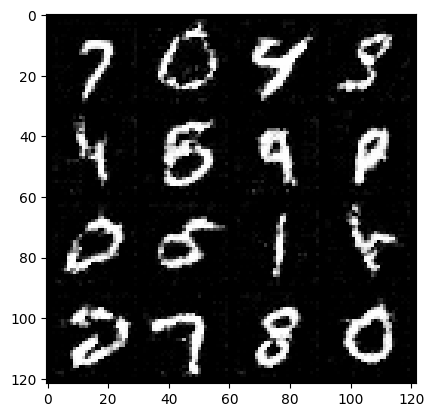

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6224939096202728 | G_loss : 0.8191121226943123


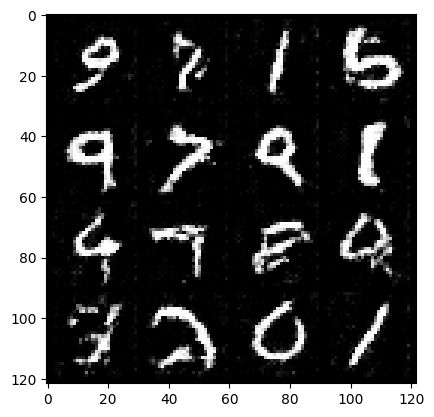

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6247581919627403 | G_loss : 0.818964462671707


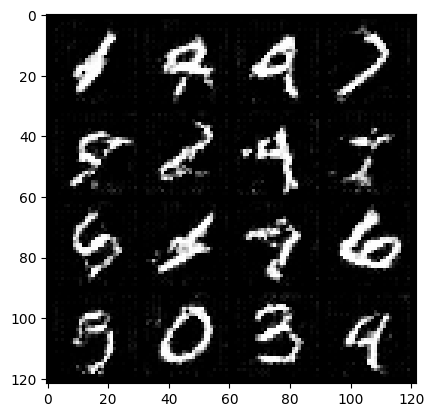

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6284605737434013 | G_loss : 0.8207044590002438


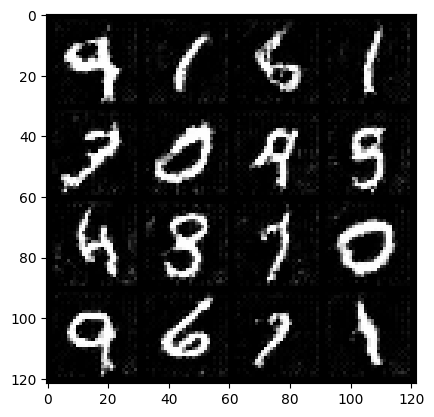

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6305597331732321 | G_loss : 0.8222678684984951


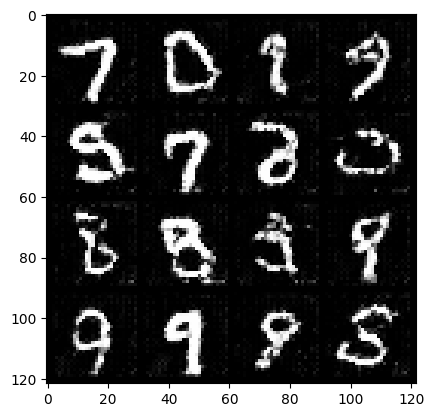

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.6350414970282044 | G_loss : 0.8175643779067342


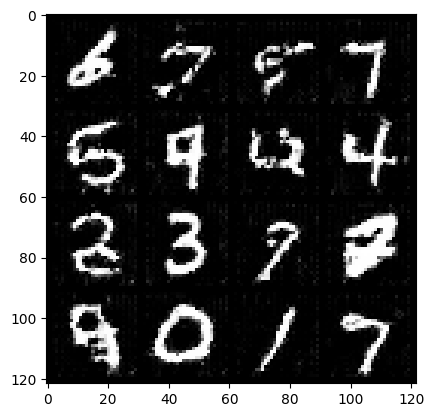

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6362857392856053 | G_loss : 0.8180924436685119


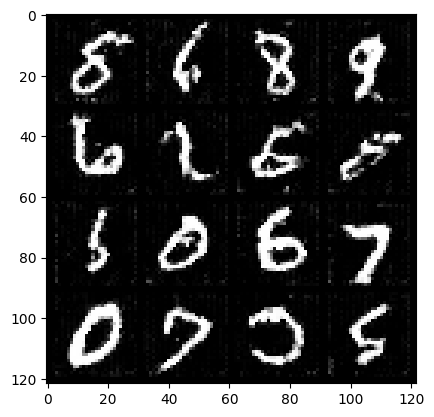

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6390650878582936 | G_loss : 0.8164833082573246


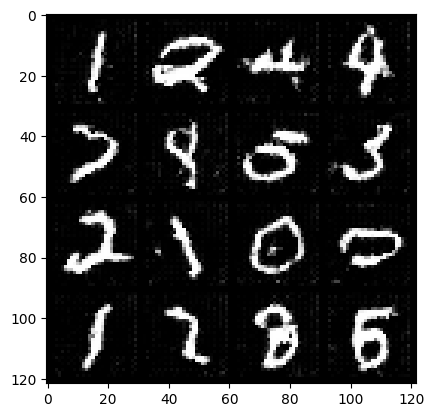

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.639955727403352 | G_loss : 0.8134501773411277


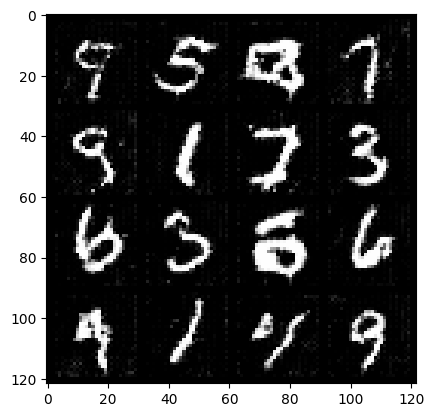

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.6412694532988168 | G_loss : 0.8139037564873441


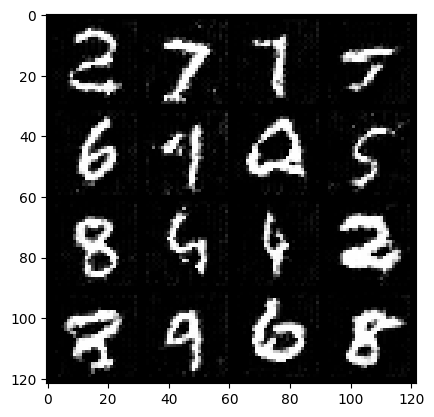

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6417312172175978 | G_loss : 0.814732759110709


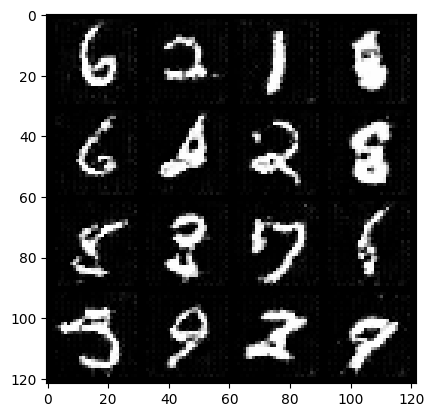

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.6436454031004835 | G_loss : 0.8107482412222352


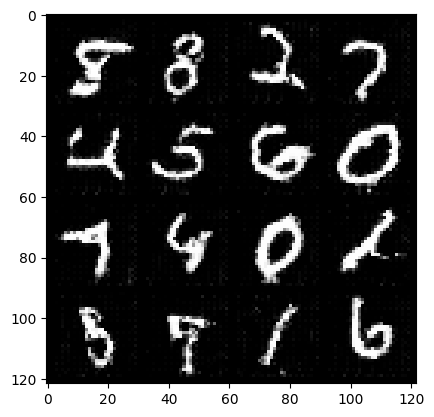

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6434303031547237 | G_loss : 0.8122492864696201


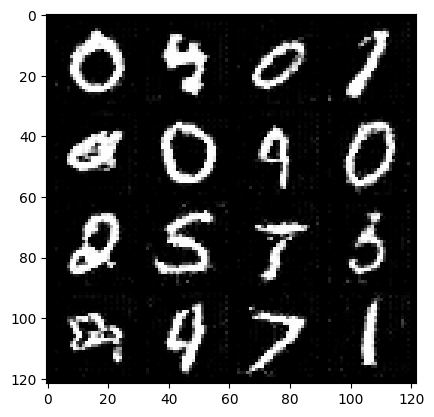

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.6448299371357411 | G_loss : 0.8155042501146605


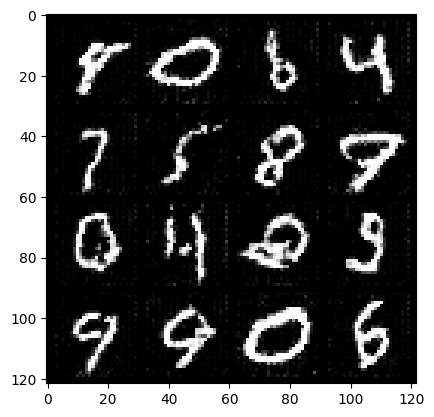

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 21 | D_loss : 0.6424055346039567 | G_loss : 0.8152391941054289


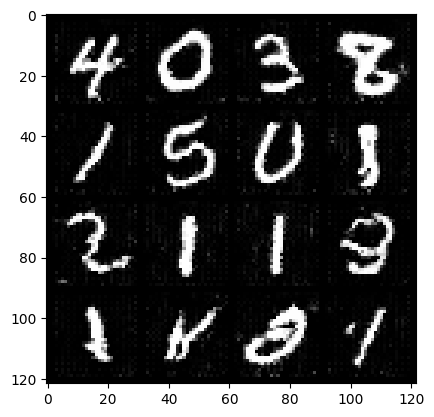

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 22 | D_loss : 0.6438899270252887 | G_loss : 0.8173413595665239


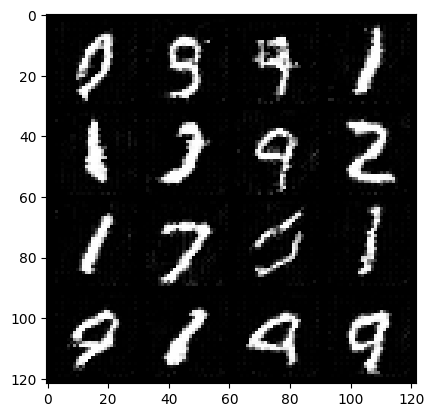

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 23 | D_loss : 0.643407484361612 | G_loss : 0.8177035963103207


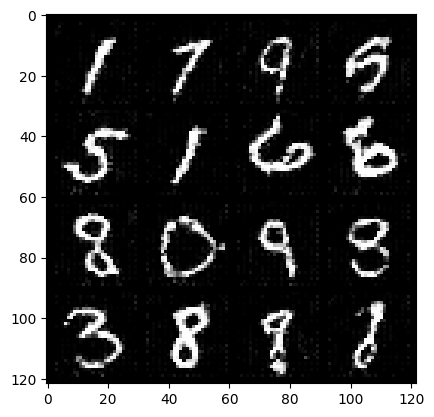

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 24 | D_loss : 0.6447273597025922 | G_loss : 0.8178994245112323


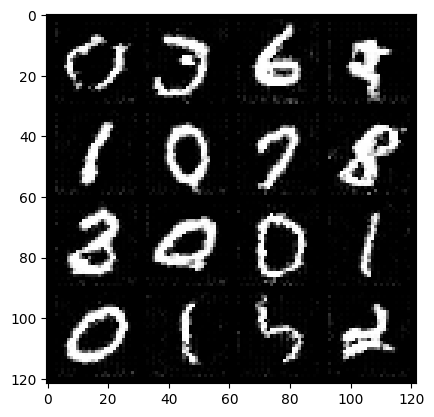

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 25 | D_loss : 0.6425869785138031 | G_loss : 0.8199895821146365


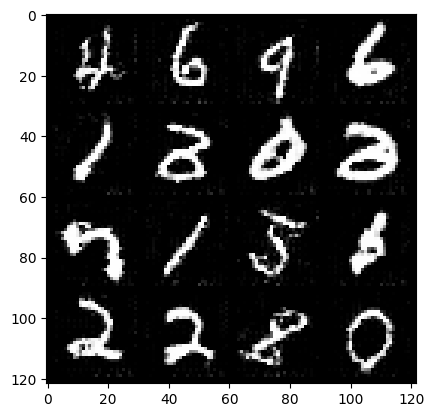

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 26 | D_loss : 0.6430890979543169 | G_loss : 0.8215411259675585


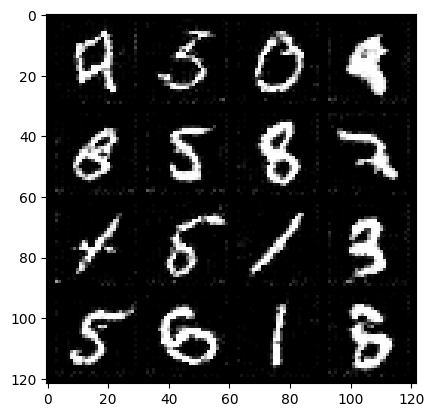

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 27 | D_loss : 0.6430063843727112 | G_loss : 0.8225238738792029


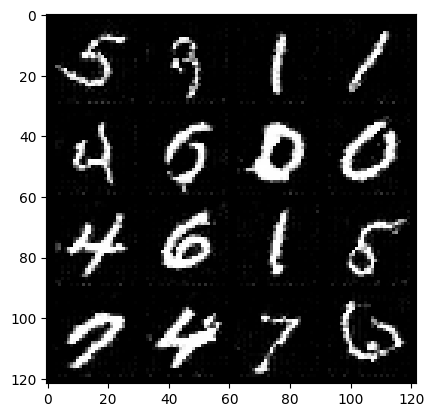

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 28 | D_loss : 0.6450891822640067 | G_loss : 0.824327373047119


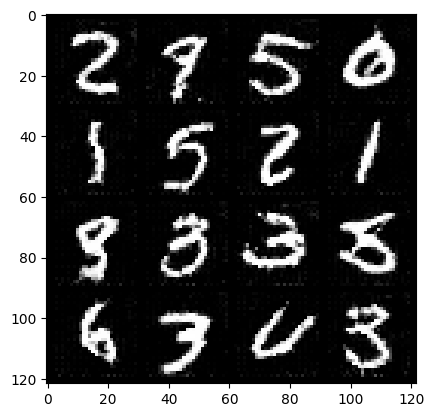

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 29 | D_loss : 0.6435736590611146 | G_loss : 0.8216741711600248


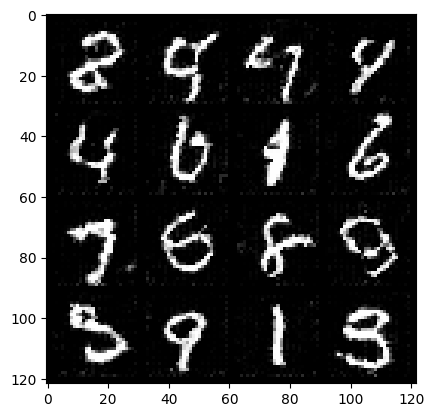

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 30 | D_loss : 0.6420284822297249 | G_loss : 0.8234477060944286


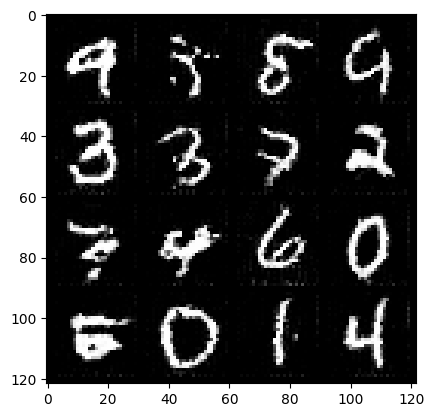

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 31 | D_loss : 0.6414530849151774 | G_loss : 0.8282121878697165


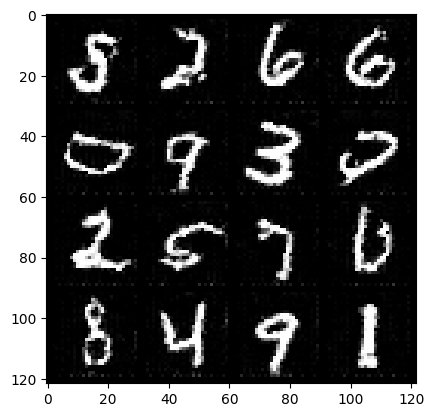

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 32 | D_loss : 0.6422530857484732 | G_loss : 0.8295362918361672


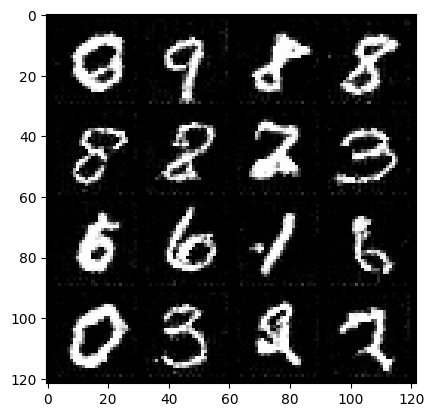

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 33 | D_loss : 0.6419950160644711 | G_loss : 0.830525576305796


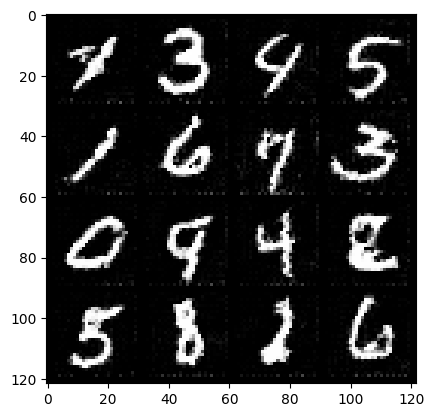

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 34 | D_loss : 0.6396421431732584 | G_loss : 0.8302865989172636


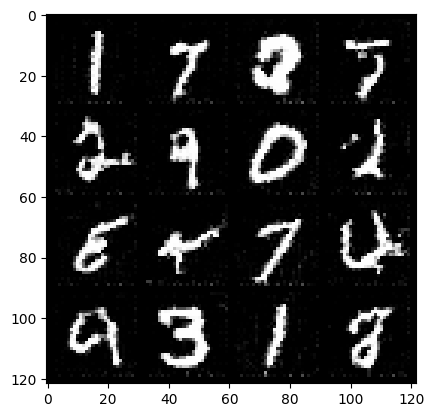

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 35 | D_loss : 0.6375269394185243 | G_loss : 0.834494408259768


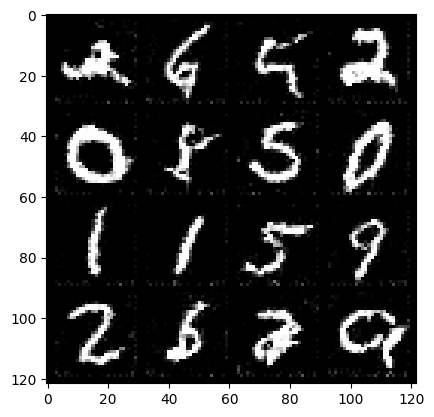

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 36 | D_loss : 0.6378315926106499 | G_loss : 0.8364693241587071


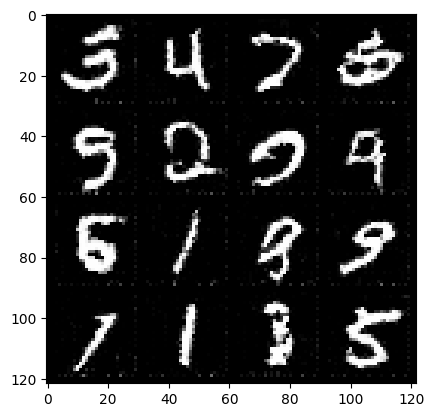

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 37 | D_loss : 0.6389226307238597 | G_loss : 0.8371369707813141


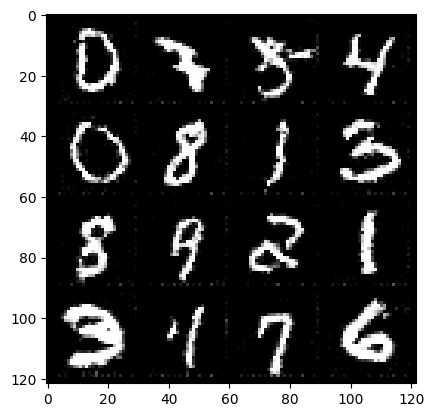

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 38 | D_loss : 0.63688986019285 | G_loss : 0.8440279547593741


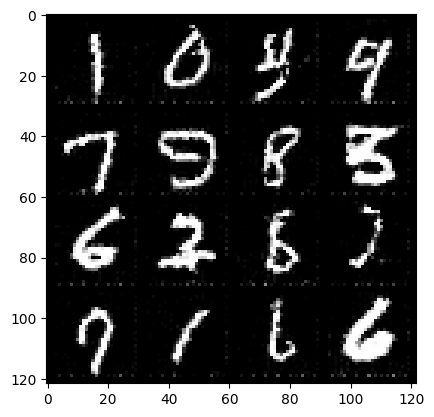

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 39 | D_loss : 0.6366093645472009 | G_loss : 0.841396348181564


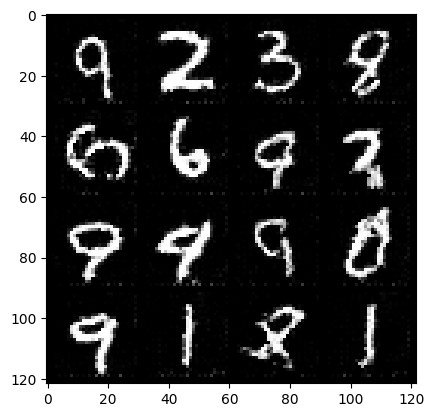

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 40 | D_loss : 0.6348588356077035 | G_loss : 0.845123502237202


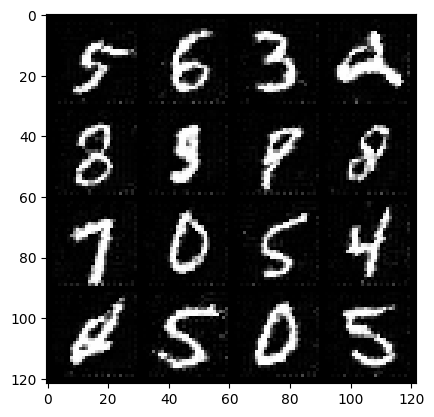

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 41 | D_loss : 0.6351907560820265 | G_loss : 0.8452286105166112


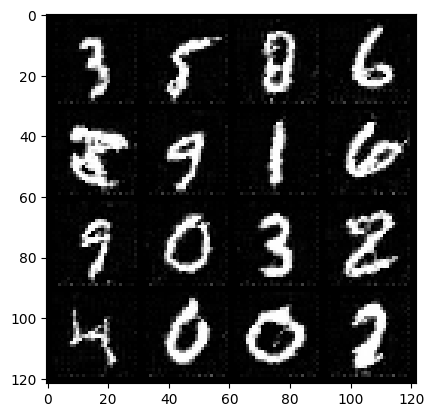

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 42 | D_loss : 0.6362981498876868 | G_loss : 0.8505515471450301


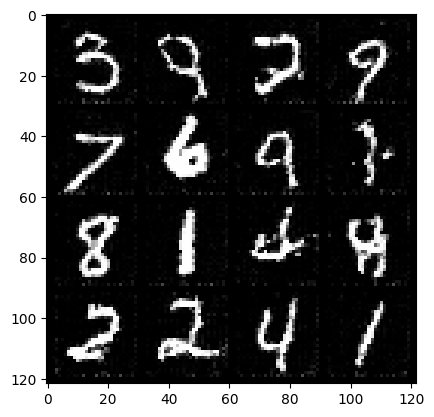

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 43 | D_loss : 0.6354521600676498 | G_loss : 0.8508229095544388


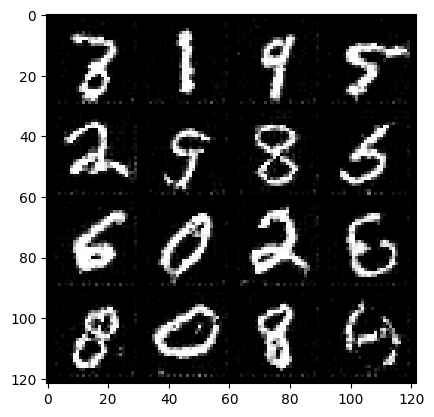

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 44 | D_loss : 0.6336529823000243 | G_loss : 0.8545759879449791


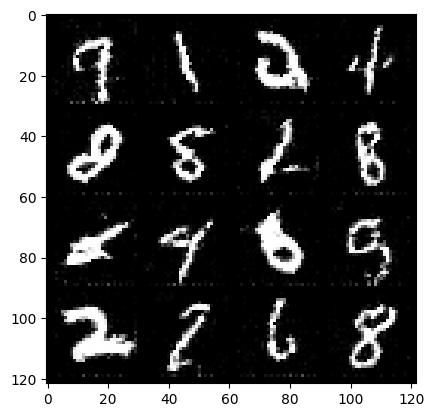

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 45 | D_loss : 0.6351688929966518 | G_loss : 0.8503702976810399


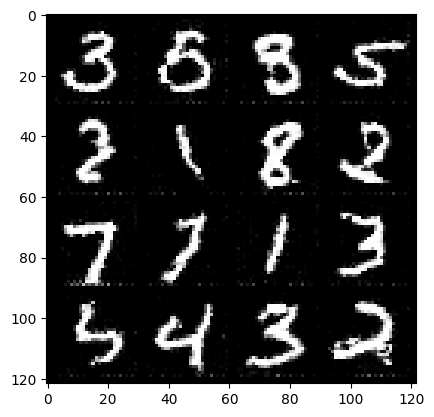

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 46 | D_loss : 0.6330123875441074 | G_loss : 0.856048189373667


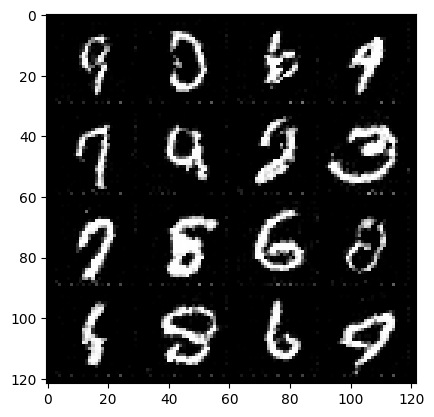

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 47 | D_loss : 0.6330081387115186 | G_loss : 0.8567455091964461


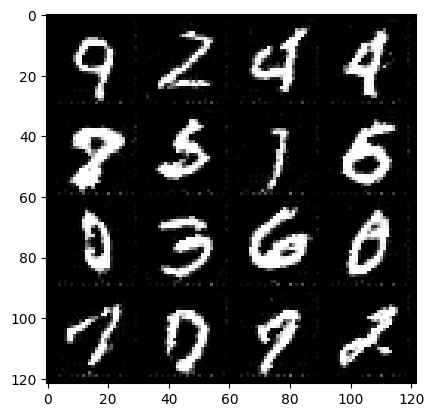

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 48 | D_loss : 0.6344443091959842 | G_loss : 0.860028854311148


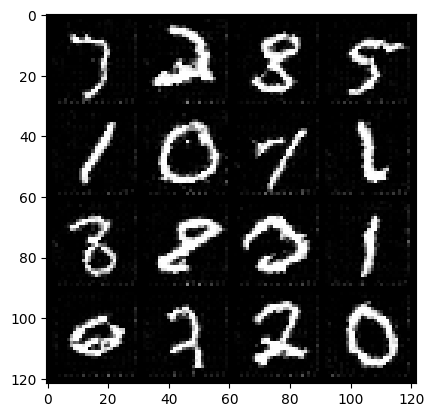

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 49 | D_loss : 0.6317217483449338 | G_loss : 0.8608397481792263


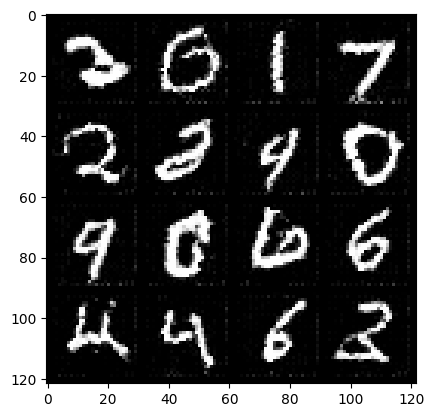

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 50 | D_loss : 0.6311652312146575 | G_loss : 0.8667679725171152


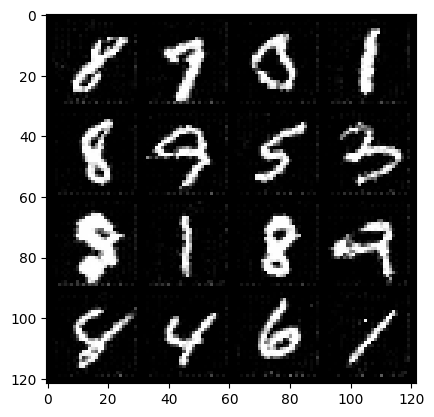

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 51 | D_loss : 0.6306883988858286 | G_loss : 0.8699487863319006


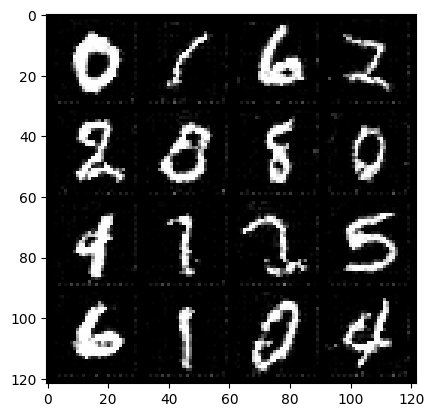

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 52 | D_loss : 0.6309601916178965 | G_loss : 0.8676873760691075


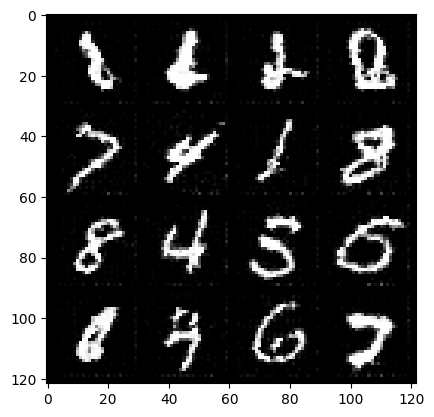

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 53 | D_loss : 0.6290091157976244 | G_loss : 0.8741519172816897


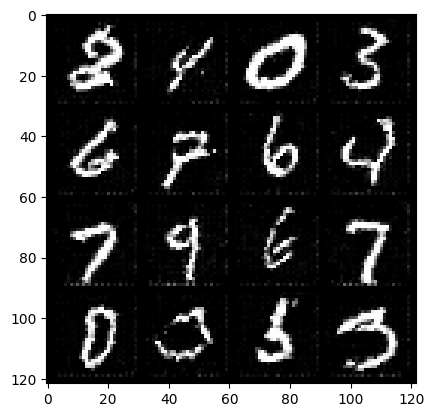

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 54 | D_loss : 0.6289738392524882 | G_loss : 0.8690998467809355


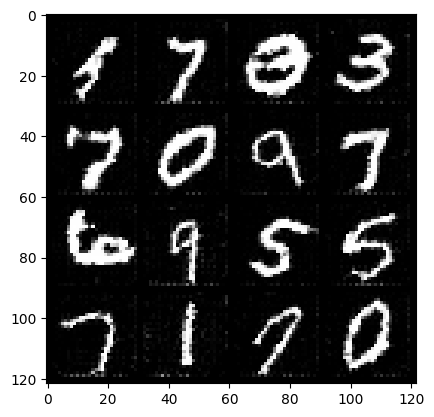

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 55 | D_loss : 0.6284157344018981 | G_loss : 0.8733709924764979


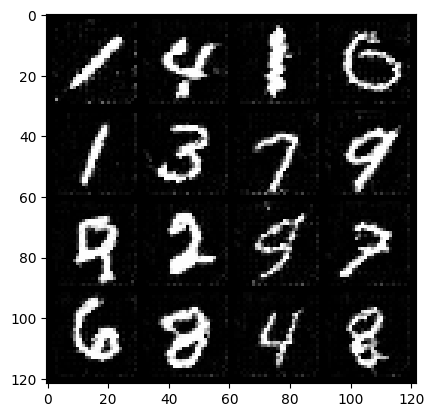

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 56 | D_loss : 0.6279036651796369 | G_loss : 0.8754438823982597


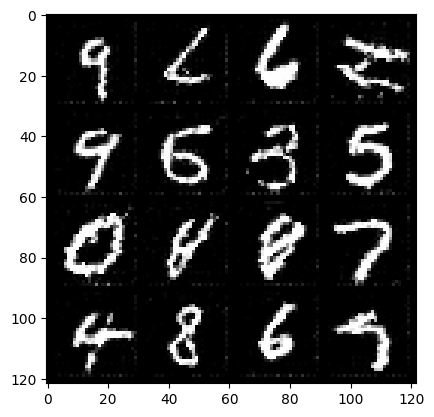

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 57 | D_loss : 0.627789176095015 | G_loss : 0.8780434962783032


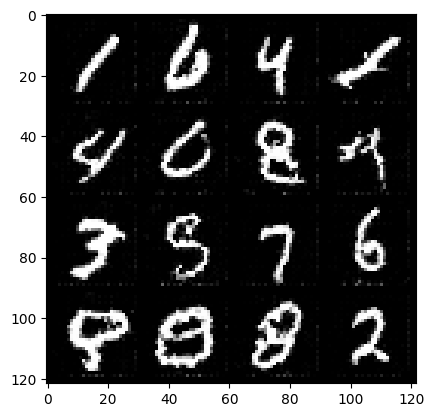

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 58 | D_loss : 0.6286853689120523 | G_loss : 0.8767370317282199


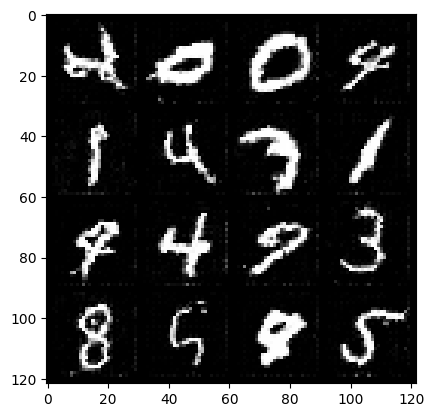

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 59 | D_loss : 0.6287806208199783 | G_loss : 0.8771775387751777


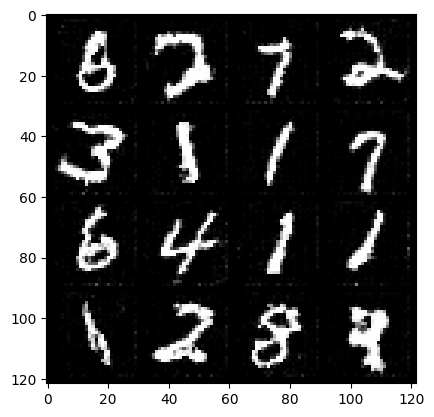

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 60 | D_loss : 0.626827701068382 | G_loss : 0.8803465615457563


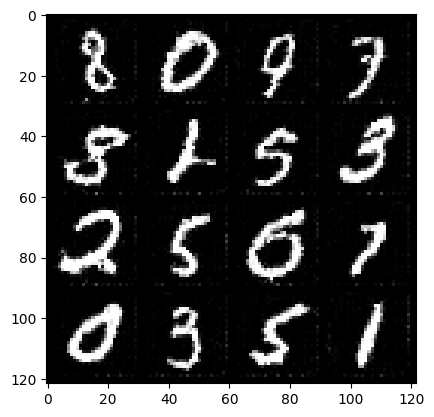

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 61 | D_loss : 0.6293702909687181 | G_loss : 0.8767659933582298


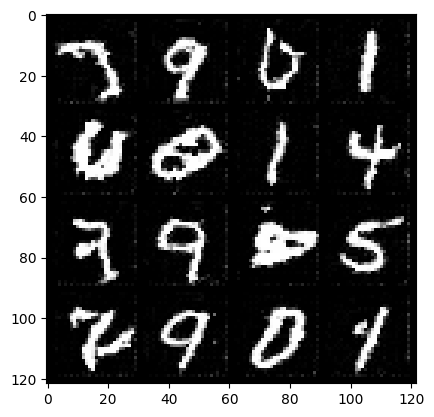

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 62 | D_loss : 0.6278188733149693 | G_loss : 0.8783162142167976


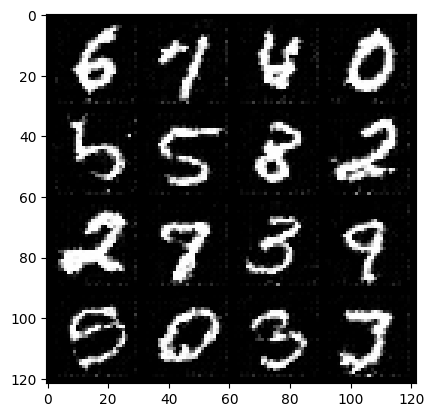

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 63 | D_loss : 0.6274133296663573 | G_loss : 0.8800167023245968


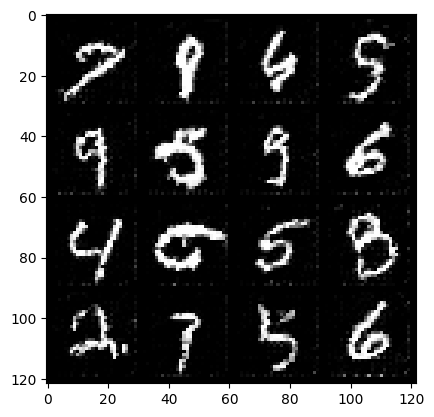

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 64 | D_loss : 0.6295332387566313 | G_loss : 0.8739866383040129


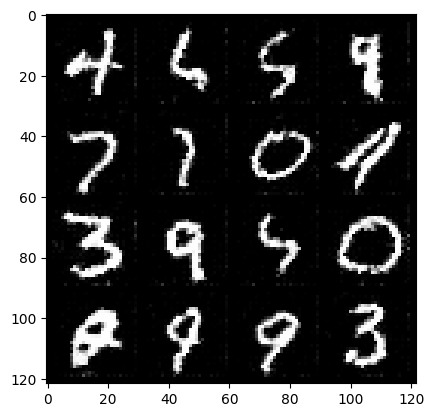

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 65 | D_loss : 0.6282127375033364 | G_loss : 0.8830106182139057


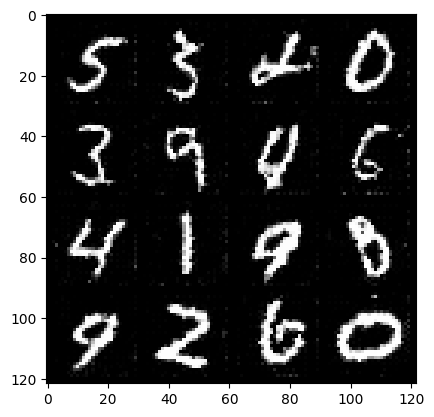

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 66 | D_loss : 0.6286262773247416 | G_loss : 0.8821906502058765


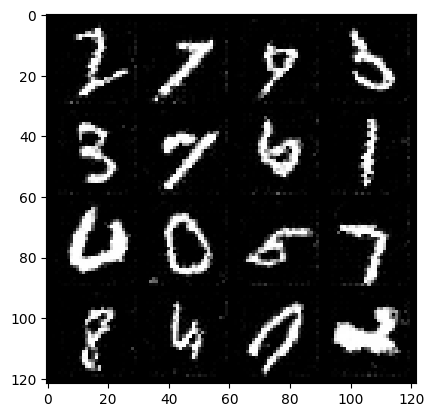

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 67 | D_loss : 0.6306249351897982 | G_loss : 0.8774467843936197


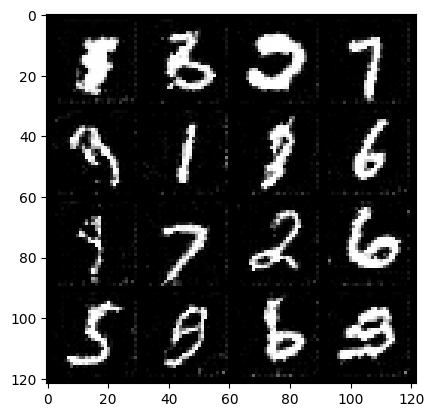

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 68 | D_loss : 0.6306600260582051 | G_loss : 0.877872960526806


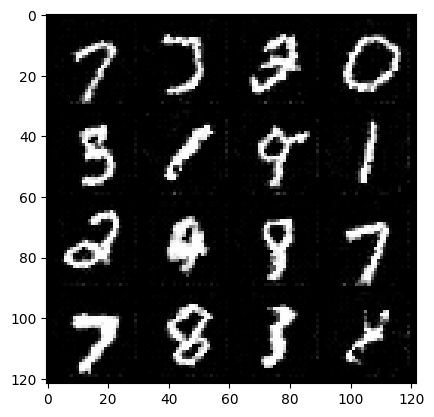

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 69 | D_loss : 0.6306805816540586 | G_loss : 0.8788768641475929


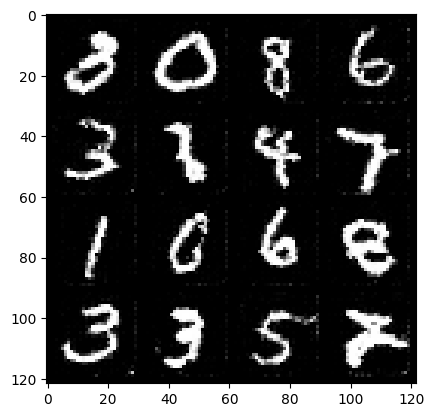

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 70 | D_loss : 0.6286663566825232 | G_loss : 0.883027612781728


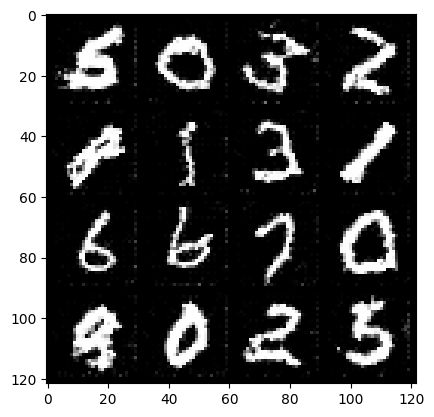

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 71 | D_loss : 0.6310800850264299 | G_loss : 0.882463817149083


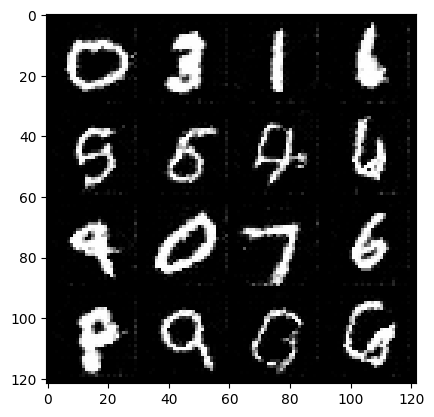

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 72 | D_loss : 0.630373039987804 | G_loss : 0.8793211229828629


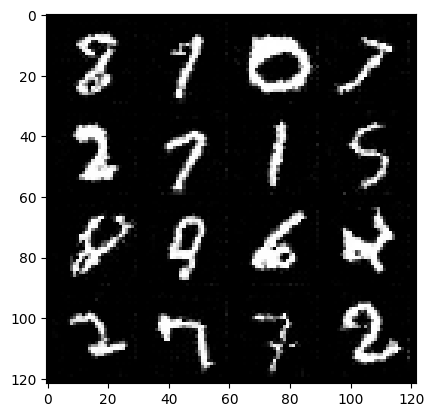

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 73 | D_loss : 0.6311319992740525 | G_loss : 0.8772253739808414


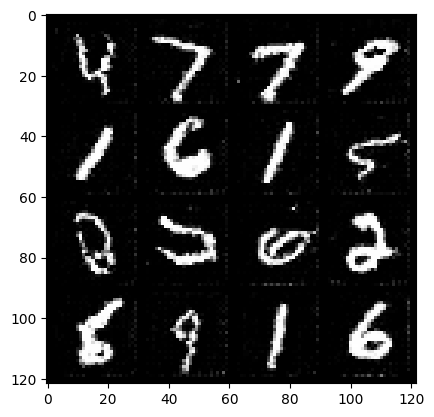

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 74 | D_loss : 0.6329354590444423 | G_loss : 0.8757758102437326


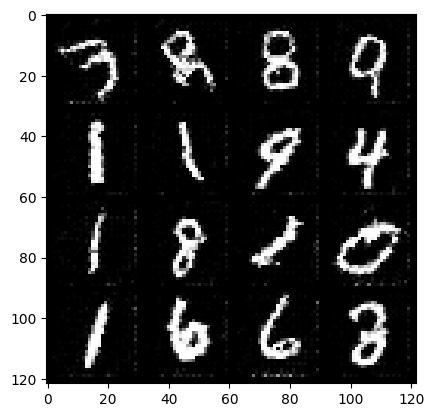

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 75 | D_loss : 0.6333789674203787 | G_loss : 0.8748776677574939


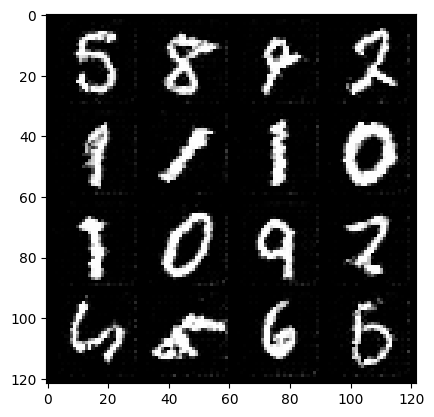

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 76 | D_loss : 0.6317315391385987 | G_loss : 0.8746778662525007


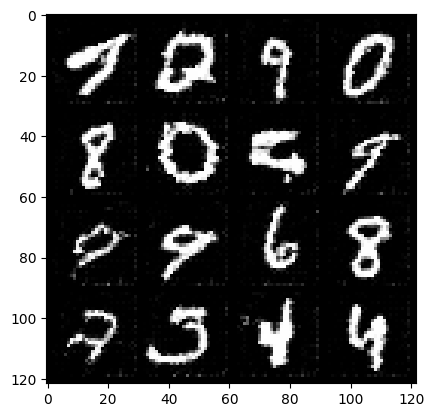

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 77 | D_loss : 0.6308135782986053 | G_loss : 0.8792666714074515


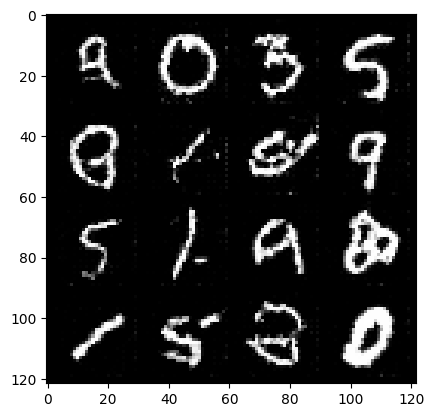

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 78 | D_loss : 0.6323828434130785 | G_loss : 0.8773839795259016


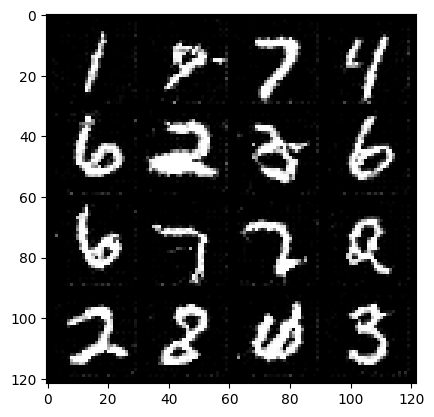

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 79 | D_loss : 0.6309504195062845 | G_loss : 0.8850282034131763


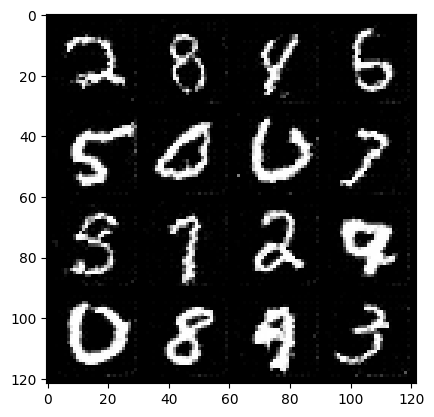

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 80 | D_loss : 0.6326693656093785 | G_loss : 0.8723414020497662


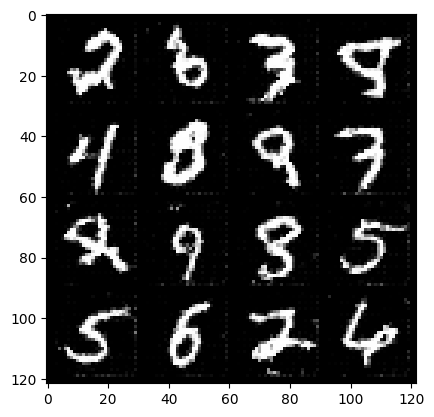

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 81 | D_loss : 0.6346857222412695 | G_loss : 0.8757809676341156


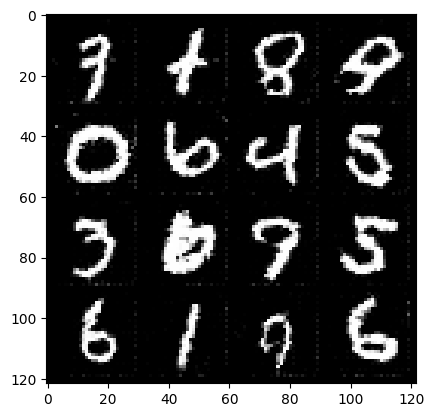

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 82 | D_loss : 0.6331978900346167 | G_loss : 0.8743705218280556


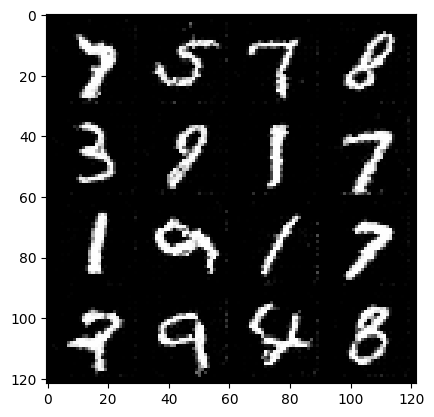

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 83 | D_loss : 0.6344843337784952 | G_loss : 0.8793894635843061


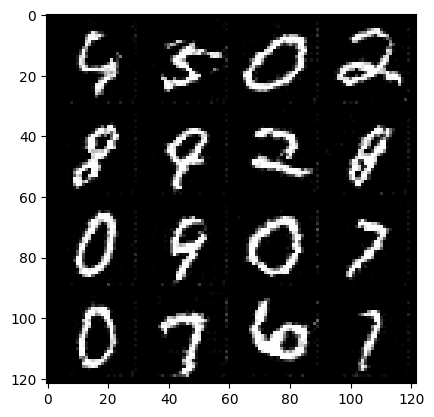

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 84 | D_loss : 0.6337836852460019 | G_loss : 0.8761446897917465


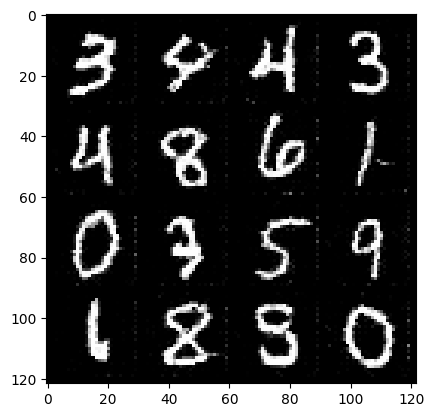

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 85 | D_loss : 0.6349111720443026 | G_loss : 0.8777222450353952


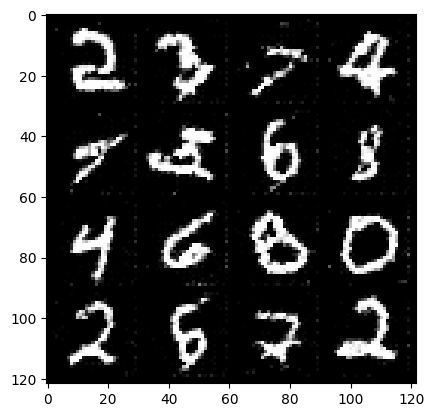

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 86 | D_loss : 0.6364613458800163 | G_loss : 0.8726988860539028


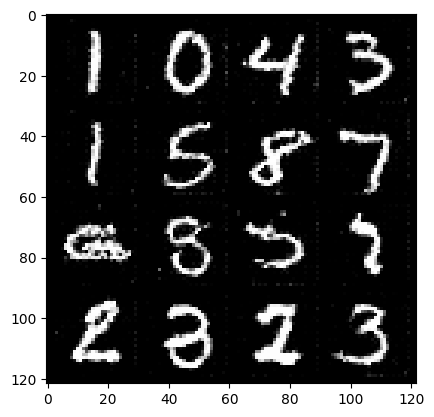

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 87 | D_loss : 0.6349072912608636 | G_loss : 0.867166288753054


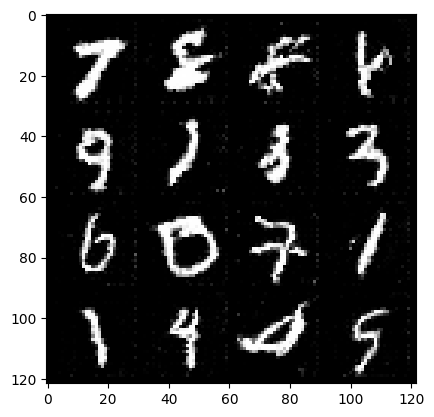

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 88 | D_loss : 0.6344989758056364 | G_loss : 0.8755822681160624


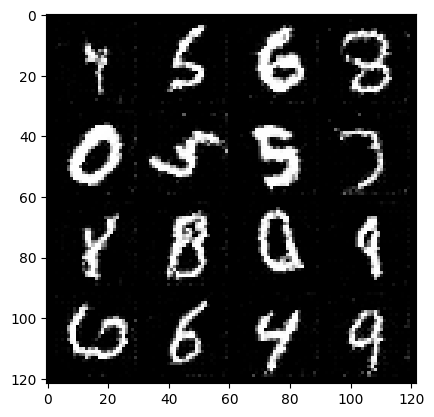

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 89 | D_loss : 0.6353025592720585 | G_loss : 0.872327111804409


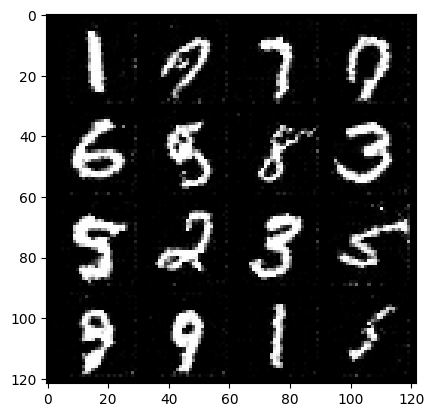

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 90 | D_loss : 0.6366838092234597 | G_loss : 0.8740901716990765


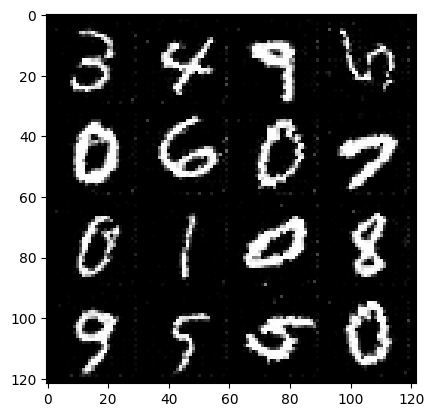

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 91 | D_loss : 0.6354020793300702 | G_loss : 0.8691395253006583


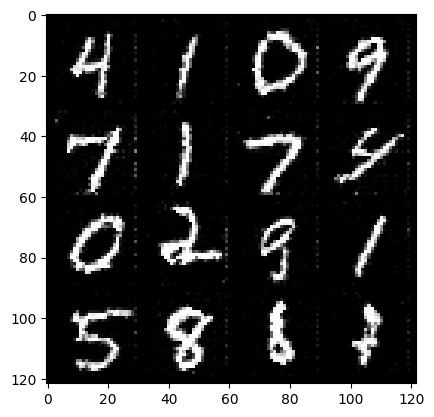

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 92 | D_loss : 0.6364362000910713 | G_loss : 0.8713538431917934


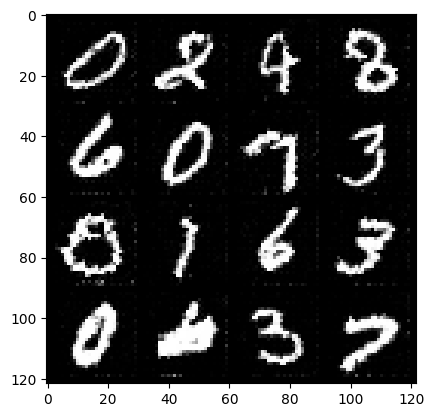

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 93 | D_loss : 0.6343953014690993 | G_loss : 0.8732235882836364


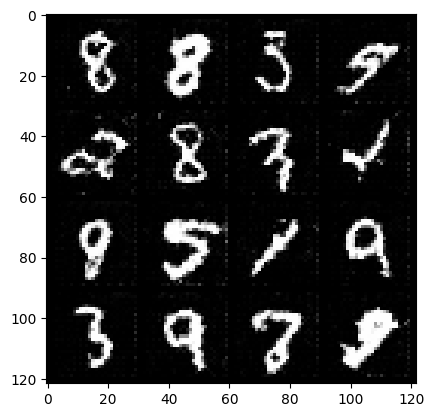

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 94 | D_loss : 0.6364045327406194 | G_loss : 0.8732039732719535


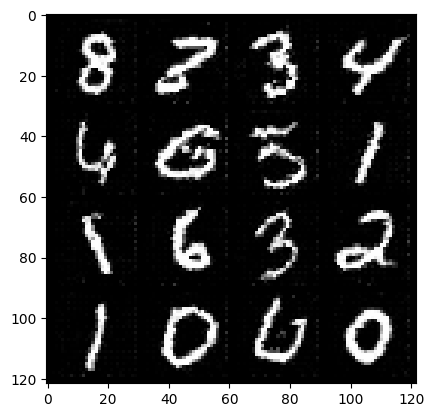

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 95 | D_loss : 0.6364925784597011 | G_loss : 0.8698170834512853


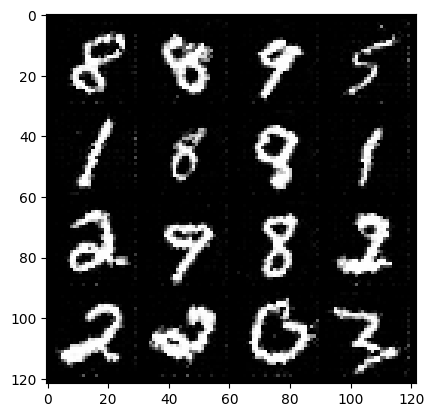

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 96 | D_loss : 0.6370310229279085 | G_loss : 0.8683023776835216


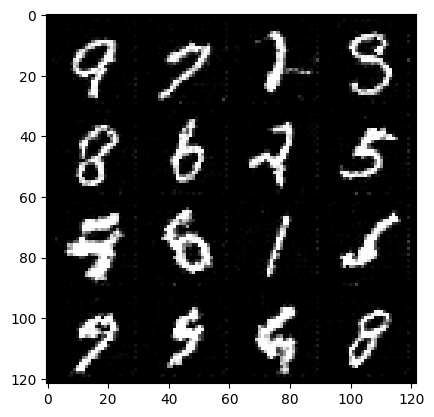

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 97 | D_loss : 0.6361657775033003 | G_loss : 0.8701769662564243


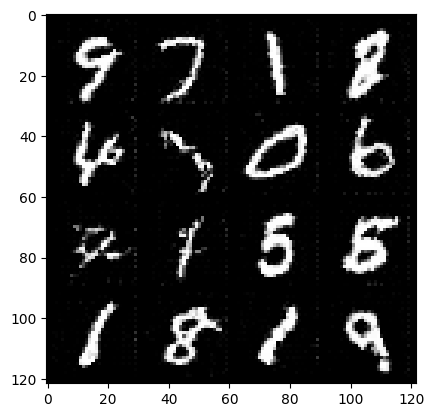

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 98 | D_loss : 0.6378663014501397 | G_loss : 0.8730677764044642


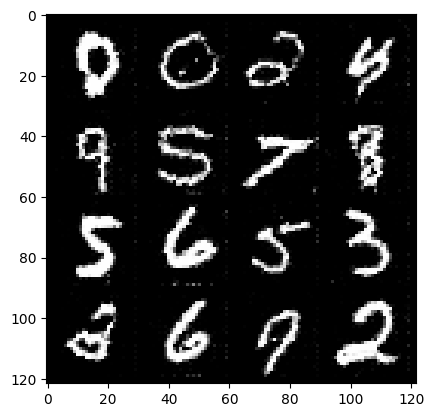

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 99 | D_loss : 0.6356490969912075 | G_loss : 0.8769848004841347


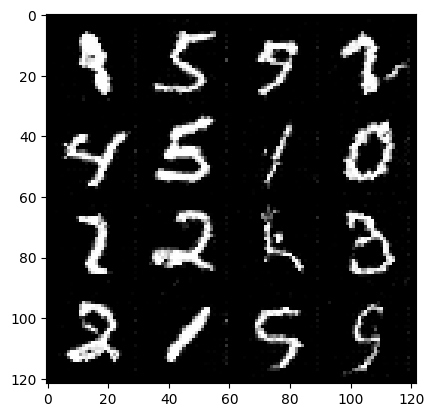

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 100 | D_loss : 0.63459353304621 | G_loss : 0.8771683473322691


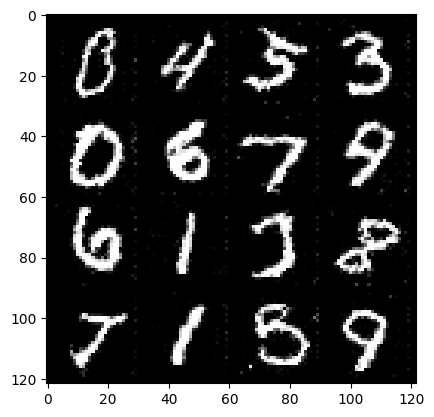

In [ ]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss) / 2

    total_d_loss += D_loss.item()

    # freeze generator
    for param in G.parameters():
            param.requires_grad = False

    D_loss.backward()
    D_opt.step()

    # unfreeze genetor
    for param in G.parameters():
            param.requires_grad = True

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    # freeze discriminator
    for param in D.parameters():
            param.requires_grad = False

    G_loss.backward()
    G_opt.step()

    # unfreeze disciminator
    for param in D.parameters():
            param.requires_grad = True

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch : {} | D_loss : {} | G_loss : {}".format(i + 1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

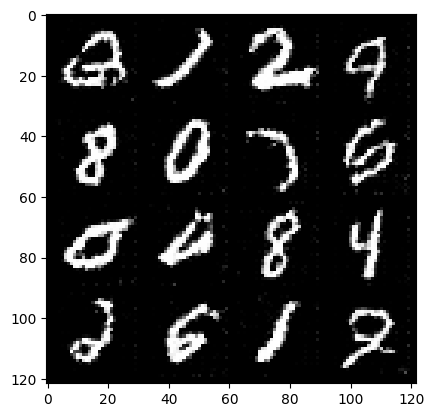

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya